# url: https://qiita.com/inoshun/items/1e7348100f80d832f403

# 決定木モデルを可視化しよう！

## はじめに
皆さんはPythonのライブラリであるdtreevizについて知っていますか？
今回はdtreevizを用いたLightGBMの決定木モデルを可視化していこうと思います。

## dtreevizとは
決定木（Decision Trees）の視覚化をサポートしたPythonライブラリです。決定木の各ノードでの決定の詳細を色分けされたノードやパス、ヒストグラムなどのリッチなグラフィクスで表現することができます。

主な機能としては

    1.ツリーの各ノードでのデータの分布を示すヒストグラムやバープロット
    2.クラスの分布や平均値などのツリーの各ノードの詳細情報
    3.ノードの色分けによるクラスや目的変数の値の分布の視覚化
    4.ターゲット変数の分布や主要な特徴量の影響を示すシャドウツリーの表示

があります。

詳細は以下のGitリポジトリを参考にしてみてください。
今回は、私がよく使用しているLightGBMのモデルを可視化していこうと思います。

https://github.com/parrt/dtreeviz

## コード内容

実行環境はvscodeのJupyterNotebookを使用します。
必要に応じてファイルを作成してください。
pythonのバージョンは3.11を使用しています。

まずはdtreevizをインストールしましょう。

それではライブラリをインポートしましょう。

In [1]:
# pip install dtreeviz

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import japanize_matplotlib
import plotly.express as px
import dtreeviz

random_state = 0

シード値は今回は固定しておきます。
0でも42でもお好きな数字を選択してください。
データに再現性を持たせるために指定しているだけですので、私と同じグラフを作成して確認していくのであればrandom_state = 0としてください。

ではデータを読み込みます。
今回はネット上からタイタニックのデータを引っ張ってきます。

In [3]:
import pandas as pd
dataset_url = 'https://raw.githubusercontent.com/parrt/dtreeviz/master/data/titanic/titanic.csv'
dataset = pd.read_csv(dataset_url)

dataset.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

はい。お馴染みのデータですね。
では、データの前処理を行っていきましょう。
Ageカラムの欠損値を平均値で補完し、Sex、Cabin、Embarkedそれぞれのカラムをカテゴリー変数に変換します。

In [4]:
dataset.fillna({'Age':dataset.Age.mean()},inplace=True)
dataset['Sex_label'] = dataset.Sex.astype('category').cat.codes
dataset['Cabin_label'] = dataset.Cabin.astype('category').cat.codes
dataset['Embarked_label'] = dataset.Embarked.astype('category').cat.codes

今回は分類モデルと回帰モデルの2パターンで可視化していきます。

## 分類モデル
今回モデルの学習に使用する特徴量とターゲットを指定し、トレーニングデータとテストデータに分割します。
また、モデル用のトレーニングデータとバリデーションデータのデータセットを作成しておきます。
ここでもシード値を選択しています。値はお任せします。

データセットは引数としてdata：特徴量、label：ターゲット、feature_name：特徴量の名前、categorical_feature：カテゴリカル特徴量を設定してますが、特徴量とターゲット以外はなくてもOKです。



In [5]:
features = ['Pclass','Sex_label','Embarked_label','Age','Cabin_label','Fare']
target = 'Survived'

X_train, X_test, y_train, y_test = train_test_split(dataset[features], dataset[target], test_size=0.2 ,random_state=42)

train_data = lgb.Dataset(data = X_train, label = y_train, feature_name = features, categorical_feature = ['Sex_label','Pclass'])
valid_data = lgb.Dataset(data = X_test, label = y_test, feature_name = features, categorical_feature = ['Sex_label','Pclass'])

次にLightGBMのハイパーパラメータの設定をし、さっそくモデルを学習させていきます。
ここでは、バリデーションデータとしてトレーニングデータとバリデーションデータの両方を指定しています。

両方指定する理由は

    モデルの評価とチューニング: バリデーションデータセットを使用することで、モデルの性能を評価し、ハイパーパラメータの調整（ハイパーパラメータチューニング）を行うための指標を持つことができます。モデルの性能が過剰適合または過小適合しているかどうかを確認し、モデルの改善ポイントを特定するのに役立ちます。

    過学習の検出: トレーニングデータセットでの性能が高い場合、モデルが過学習している可能性があります。バリデーションデータセットを使用することで、モデルが新しいデータにどれだけ汎化できるかを評価し、過学習の兆候を検出できます。

    アンサンブル学習: バリデーションデータを使用して複数のモデルをトレーニングし、それらのモデルをアンサンブル（組み合わせ）することができます。これにより、モデルの予測性能を向上させることができます。

    モデルの信頼性向上: バリデーションデータを使用してモデルを評価することは、モデルの予測の信頼性を高めるのに役立ちます。モデルがバリデーションデータに対してうまく機能する場合、そのモデルは新しい未知のデータに対しても信頼性が高い可能性が高くなります。

    早期停止: バリデーションデータを使用して、トレーニング中に早期停止（early stopping）を実施することができます。モデルの性能が改善しなくなったときにトレーニングを中断し、過学習を防ぎます。

私も調べながら初めて知りました(;´･ω･)
やはり気になったことは調べるべきですね！

In [6]:
lgbm_params = {
    'boosting_type':'dart',
    'application':'binary',
    'learning_rate':0.05,
    'min_data_in_leaf':2,
    'feature_pre_filter':False,
    'feature_fraction':0.7,
    'num_leaves':41,
    'drop_rate':0.15,
    'max_depth':4,
    "seed":1212}

lgbm_model = lgb.train(lgbm_params, train_data, valid_sets=[train_data,valid_data])

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


ここでようやくdtreevizの出番です。
可視化を行います。
それぞれの引数の説明をします。

    lgbm_model：可視化させたいモデル
    tree_index：LightGBMはアンサンブル学習であるため、複数の決定木の中からインデックスを指定して可視化
    X_train：特徴量
    y_train：ターゲット
    feature_name：特徴量の名前
    target_name：ターゲット名
    class_names：分類名（今回はSurvivedがターゲットのためpersih：死亡、survive：生存の2つを指定）

In [7]:
viz_model = dtreeviz.model(lgbm_model,
                           tree_index = 1,
                           X_train = dataset[features],
                           y_train = dataset[target],
                           feature_names = features,
                           target_name = target,
                           class_names=["perish","survive"])

では、まずはグラフを作成しましょう。
ここでは、指定したインデックスの決定木の全体像を可視化します。

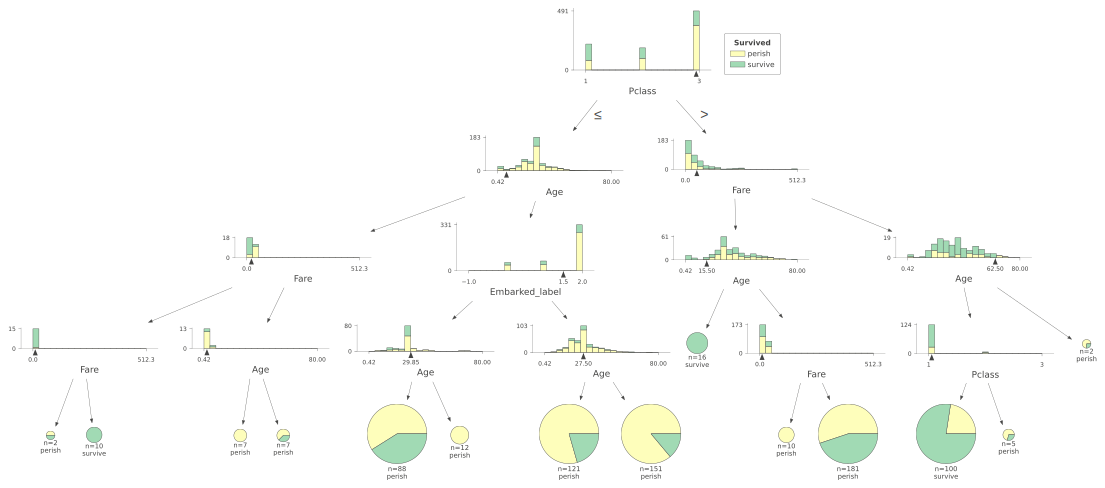

In [8]:
viz_model.view()

ちなみに横向きにしたかったら、引数にorientation = 'LR'を入れてください。

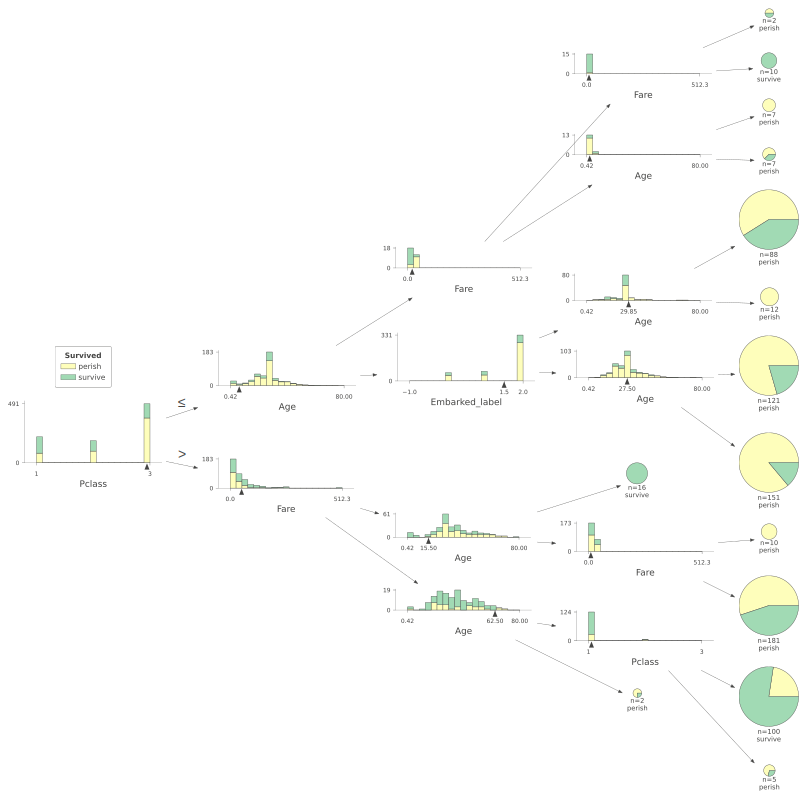

In [9]:
viz_model.view(orientation = 'LR')

引数にfancy=Falseを入れることで、視覚化のディテールや装飾をシンプルにすることができます。ツリーのノードやエッジの色、ヒストグラムやデータの分布などのリッチなグラフィクスが省略され、ツリーの主要な決定のみを強調したベーシックな決定木の視覚化が得られます。

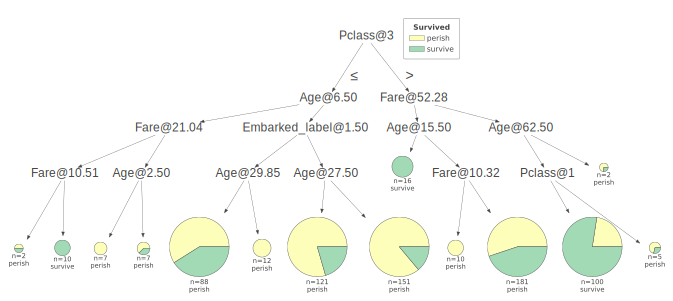

In [10]:
viz_model.view(fancy=False)

特定の深さの範囲の決定木を表示してみましょう。



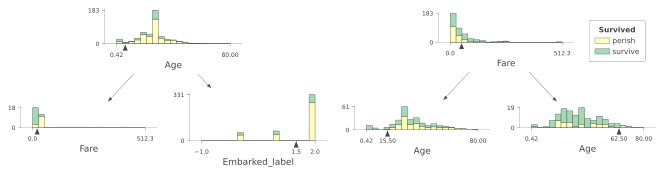

In [11]:
viz_model.view(depth_range_to_display=(1,2))

depth_range_to_display=(1,2)は表示したい決定木の深さの範囲を指定しています。
つまり、決定木の1～2の深さの部分のみを視覚化しています。
これは、非常に大きな決定木を持つときや、特定の部分のみに焦点を当てたいときに役立ちます。



データセットから特定の行を1つ取ってきてみましょう。

In [12]:
x = dataset[features].iloc[5]

今回は6行目を取ってきてみます。
では、この特定の行に対して、決定木の中でその行のデータがどのように分類または予測されるかを追跡してみましょう。
このメソッドを使用すると、指定された行が決定木を通過する際のパスを視覚的にハイライトすることができます。特定の行のデータがどのような条件や決定を経て、最終的な結果（つまり、どの葉ノードに到達するか）に至るのかを理解することができます。



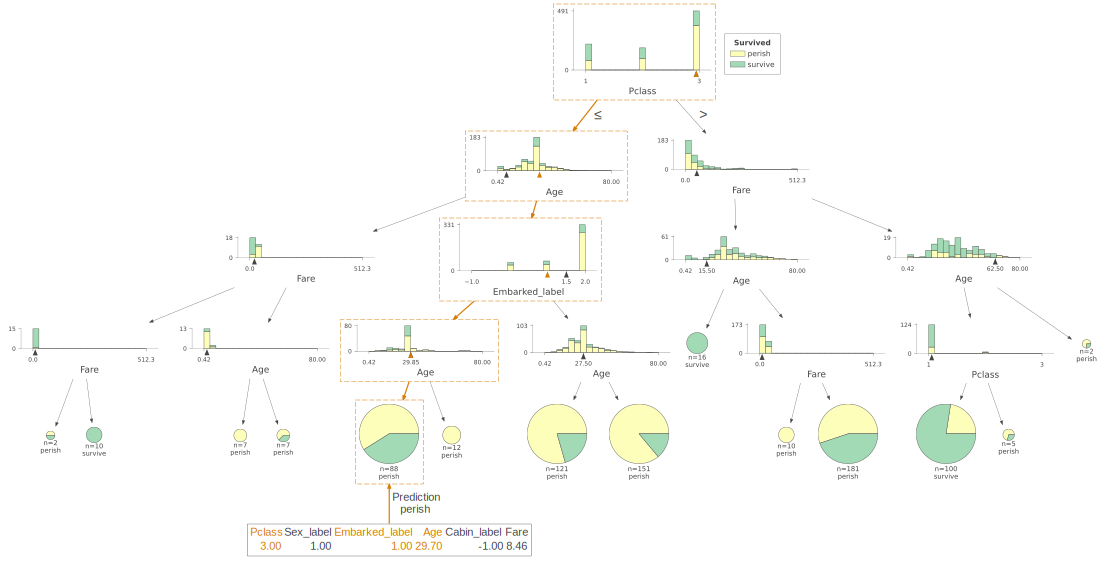

In [13]:
viz_model.view(x=x)

また、特定の行のデータのみを表示することもできます。

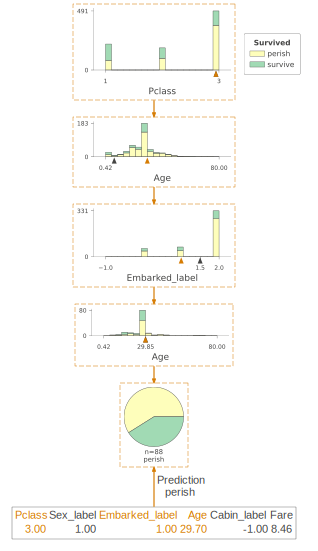

In [14]:
viz_model.view(x=x,show_just_path=True)

また、特定の行のデータが決定木を通過する際のパスをテキスト形式で表示することもできます。

In [15]:
print(viz_model.explain_prediction_path(x))

Embarked_label < 1.5
6.5 <= Age  < 29.85
Pclass in {3}  



このメソッドから次のような情報が得られます。

* xが通過する各ノードでのテスト条件
* どのノードでどの方向（例：左の子ノードまたは右の子ノード）へ移動したか
* 最終的にが到達する葉ノードとその葉ノードでの予測またはクラス分類


決定木のすべての葉ノードに到達するサンプル数を可視化してみましょう。
各葉ノードがどれだけのデータポイントをカバーしているかを理解できます。

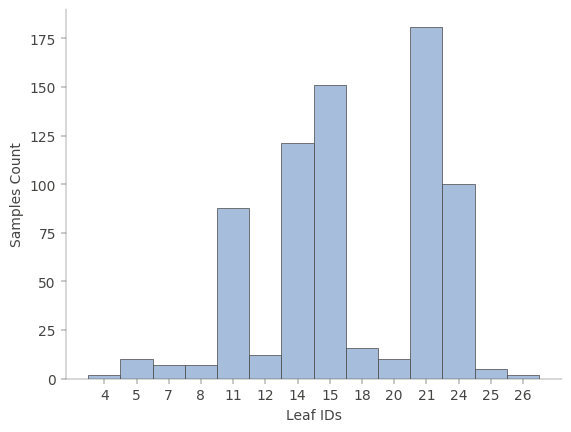

In [16]:
viz_model.leaf_sizes()

さらに各葉ノードに到達するサンプルのクラス分類をしてみましょう。
具体的には、各葉ノードでの各クラスのサンプル数を可視化することで、各葉ノードでのクラスの分布や主要なクラスを理解できます。

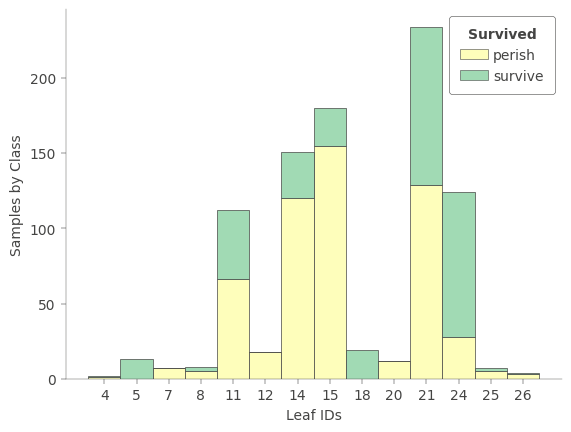

In [17]:
viz_model.ctree_leaf_distributions()

指定したノードIDに関する統計情報を確認することもできます。
このメソッドから次のような情報が得られる可能性があります。

    ノードでのテスト条件や分割条件。
    そのノードに到達するサンプル数。
    分類問題の場合、ノードに到達するサンプルのクラス分布。
    回帰問題の場合、ノードに到達するサンプルの目的変数の平均や分散などの統計情報。
    ノードの深さや位置情報。
    子ノードや親ノードとの関連情報。


In [18]:
viz_model.node_stats(node_id=21)

Pclass  Sex_label  Embarked_label        Age  Cabin_label       Fare
count     234.0      234.0           234.0      234.0        234.0      234.0
mean   1.649573    0.65812        1.662393  35.832388    21.782051  23.759009
std    0.478127   0.475357        0.742138  12.681008    42.369916  11.285105
min         1.0        0.0             0.0       16.0         -1.0       10.5
25%         1.0        0.0             2.0       28.0         -1.0       13.0
50%         2.0        1.0             2.0       32.0         -1.0       26.0
75%         2.0        1.0             2.0       44.0        23.25       29.7
max         2.0        1.0             2.0       80.0        146.0       52.0

## 回帰モデル
同様にLightGBMでモデルを学習させます。
ここではターゲットをAgeとし、回帰モデルを作成します。

In [19]:
features_reg = ["Pclass", "Fare", "Survived", "Sex_label", "Cabin_label", "Embarked_label"]
target_reg = "Age"

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(dataset[features_reg], dataset[target_reg], test_size = 0.2, random_state = 42)

categorical_feature=["Pclass", "Survived", "Sex_label"]
train_data_reg = lgb.Dataset(data = X_train_reg, label = y_train_reg)
valid_data_reg = lgb.Dataset(data = X_test_reg, label = y_test_reg)

lgbm_params = {
    'num_tree':10,
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'regression_l1',
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'drop_rate': 0.15,
    'max_depth':4,
    "seed":1212}

lgbm_reg_model = lgb.train(lgbm_params, train_data_reg, valid_sets = [train_data_reg, valid_data_reg], categorical_feature = categorical_feature)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_tree` in params. Will use it instead of argument


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 6
[LightGBM] [Info] Start training from score 29.699118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

グラフも作成します。

In [20]:
viz_rmodel = dtreeviz.model(model = lgbm_reg_model,
                            tree_index = 1,
                            X_train = dataset[features_reg],
                            y_train = dataset[target_reg],
                            feature_names = features_reg,
                            target_name = target_reg)

それでは可視化していきましょう。
コードは分類モデルと全く同じです。

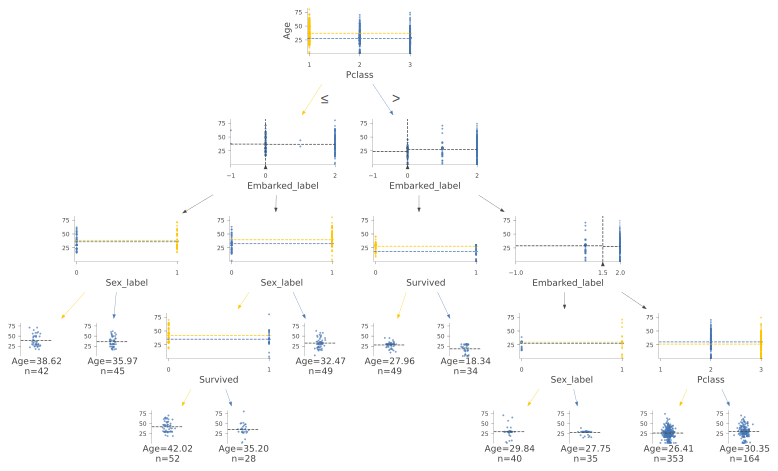

In [21]:
viz_rmodel.view()

横向き

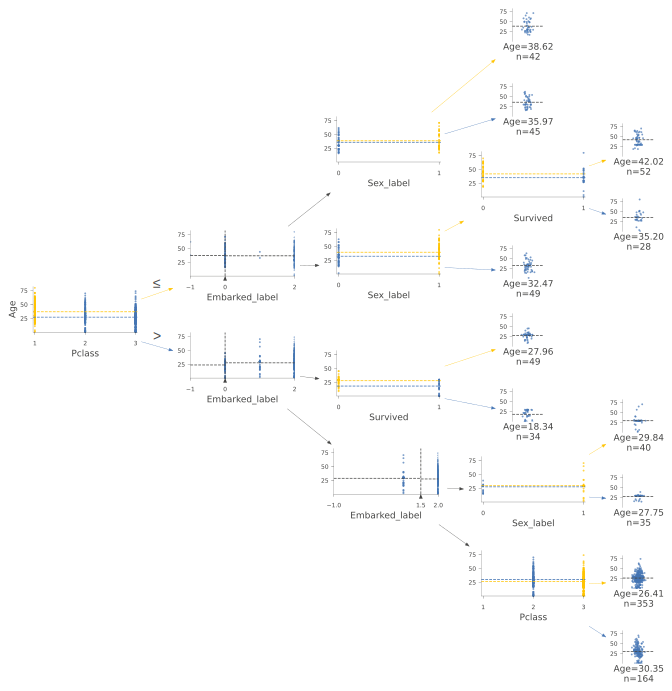

In [22]:
viz_rmodel.view(orientation="LR")

シンプル表示

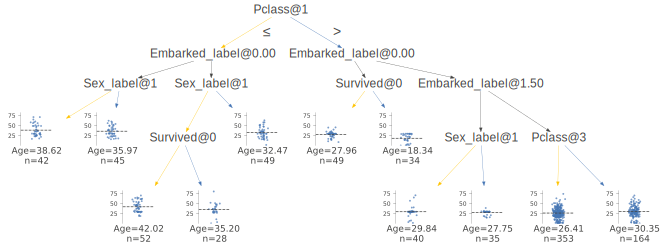

In [23]:
viz_rmodel.view(fancy=False)

深さ指定

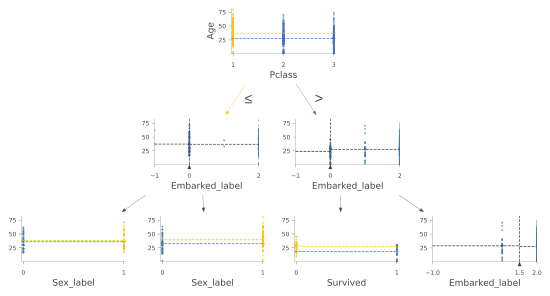

In [24]:
viz_rmodel.view(depth_range_to_display=(0, 2))

特定の行のデータのパスを表示

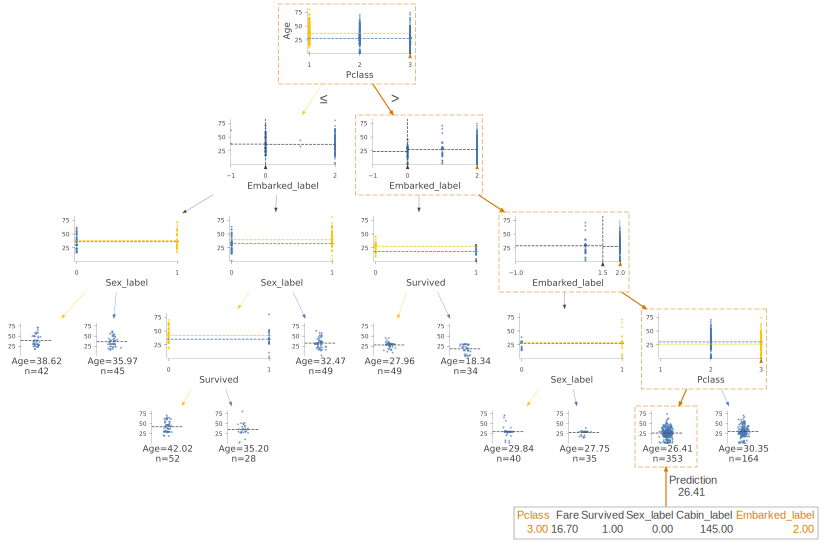

In [25]:
x = dataset[features_reg].iloc[10]
viz_rmodel.view(x = x)

特定の行のデータのみ表示

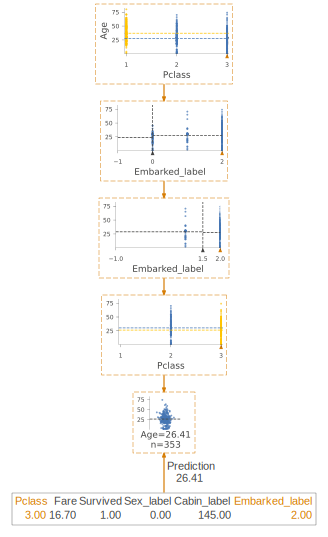

In [26]:
viz_rmodel.view(show_just_path=True, x = x)

パスをテキスト表示

In [27]:
print(viz_rmodel.explain_prediction_path(x))

1.5 <= Embarked_label 
Pclass in {3} not in {1}  



すべての葉ノードに到達するサンプル数

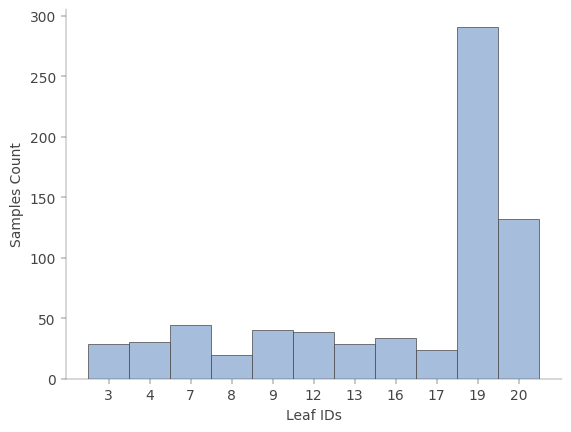

In [28]:
viz_rmodel.leaf_sizes()

## 回帰ツリーモデルの各葉ノードにおけるターゲットの分布

回帰ツリーでは、各葉ノードは通常、その葉に到達するトレーニングサンプルの目的変数の平均値としての予測を表します。ツリーの分割によって定義される特徴空間の異なる領域での目的変数の分布を理解するのに役立ちます。モデルが不確実である可能性がある領域（例えば、ある葉の目的変数の範囲が広い場合）や、モデルが確信している領域（例えば、ある葉の目的変数が非常に近い値を持つ場合）についての洞察を提供することができます。

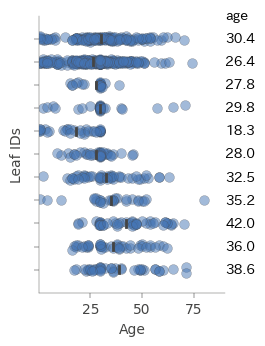

In [29]:
viz_rmodel.rtree_leaf_distributions()

特定のノードIDの統計情報

In [30]:
viz_rmodel.node_stats(node_id=19)

Pclass       Fare  Survived  Sex_label  Cabin_label  Embarked_label
count   353.0      353.0     353.0      353.0        353.0           353.0
mean      3.0  14.644083  0.189802   0.750708     2.852691             2.0
std       0.0  13.276609  0.392701   0.433217    22.686371             0.0
min       3.0        0.0       0.0        0.0         -1.0             2.0
25%       3.0     7.8542       0.0        1.0         -1.0             2.0
50%       3.0       8.05       0.0        1.0         -1.0             2.0
75%       3.0       16.1       0.0        1.0         -1.0             2.0
max       3.0      69.55       1.0        1.0        145.0             2.0

分類モデルの可視化と見た目が異なりますね。
まあ、ターゲットが違うのでそりゃそうかって感じです。

今回viz_modelとviz_rmodelを作成しましたが、簡単に説明しておきます

viz_model:
*   これは分類のための決定木またはアンサンブルモデル（LightGBMの分類モデル）の視覚化オブジェクト
*   ターゲット変数はカテゴリカルな値（生存 or 死亡）を持つ

*   viz_modelを用いると、各ノードでのクラスの分布や決定条件、葉ノードでの最終的なクラス予測など、分類のための決定木の詳細を視覚的に確認可能

viz_rmodel:

*   これは回帰のための決定木またはアンサンブルモデル（LightGBMの回帰モデル）の視覚化オブジェクト

*   ターゲット変数は連続的な値（年齢）を持つ

*   viz_rmodelを用いると、各ノードでの目的変数の平均値や分布、葉ノードでの予測値など、回帰のための決定木の詳細を視覚的に確認可能

## まとめ

ここまでお疲れさまでした！！！
お付き合いいただきありがとうございました。
今回はLightGBMの決定木の可視化を行いましたが、XGboostなど他の決定木系のモデルの可視化もできるみたいですので、興味があれば参考サイトから確認してみてください。
可視化することで、より深く考察できるようになるかもしれませんね！
皆さんのお役に立てたら幸いです。
それでは！！！



参考サイト: https://github.com/parrt/dtreeviz